# Impact of rainfall temporal distribution on flooding in Lin Dyke catchment


## Project Summary

Research suggests that the temporal distribution of rainfall within a storm event can influence the nature and severity of flooding resulting from that storm event....

Testing this using synthetic rainfall events derived from FEH/ReFH2. Standard profiles usually have one peak, testing three methods for splitting the total rainfall amount normally concentrated in this one peak into multiple peaks 

Analysing impact on the extent, depth and velocity of flooding, and the spatial distribution of these variables over the catchment

In [1]:
import os
from pathlib import Path
from PIL import Image
import geopandas as gpd
from my_functions_new import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define whether to filter out values <0.1
remove_little_values = True

model_directory = '../../../../FloodModelling/MeganModel_New/'

### Plot the clusters

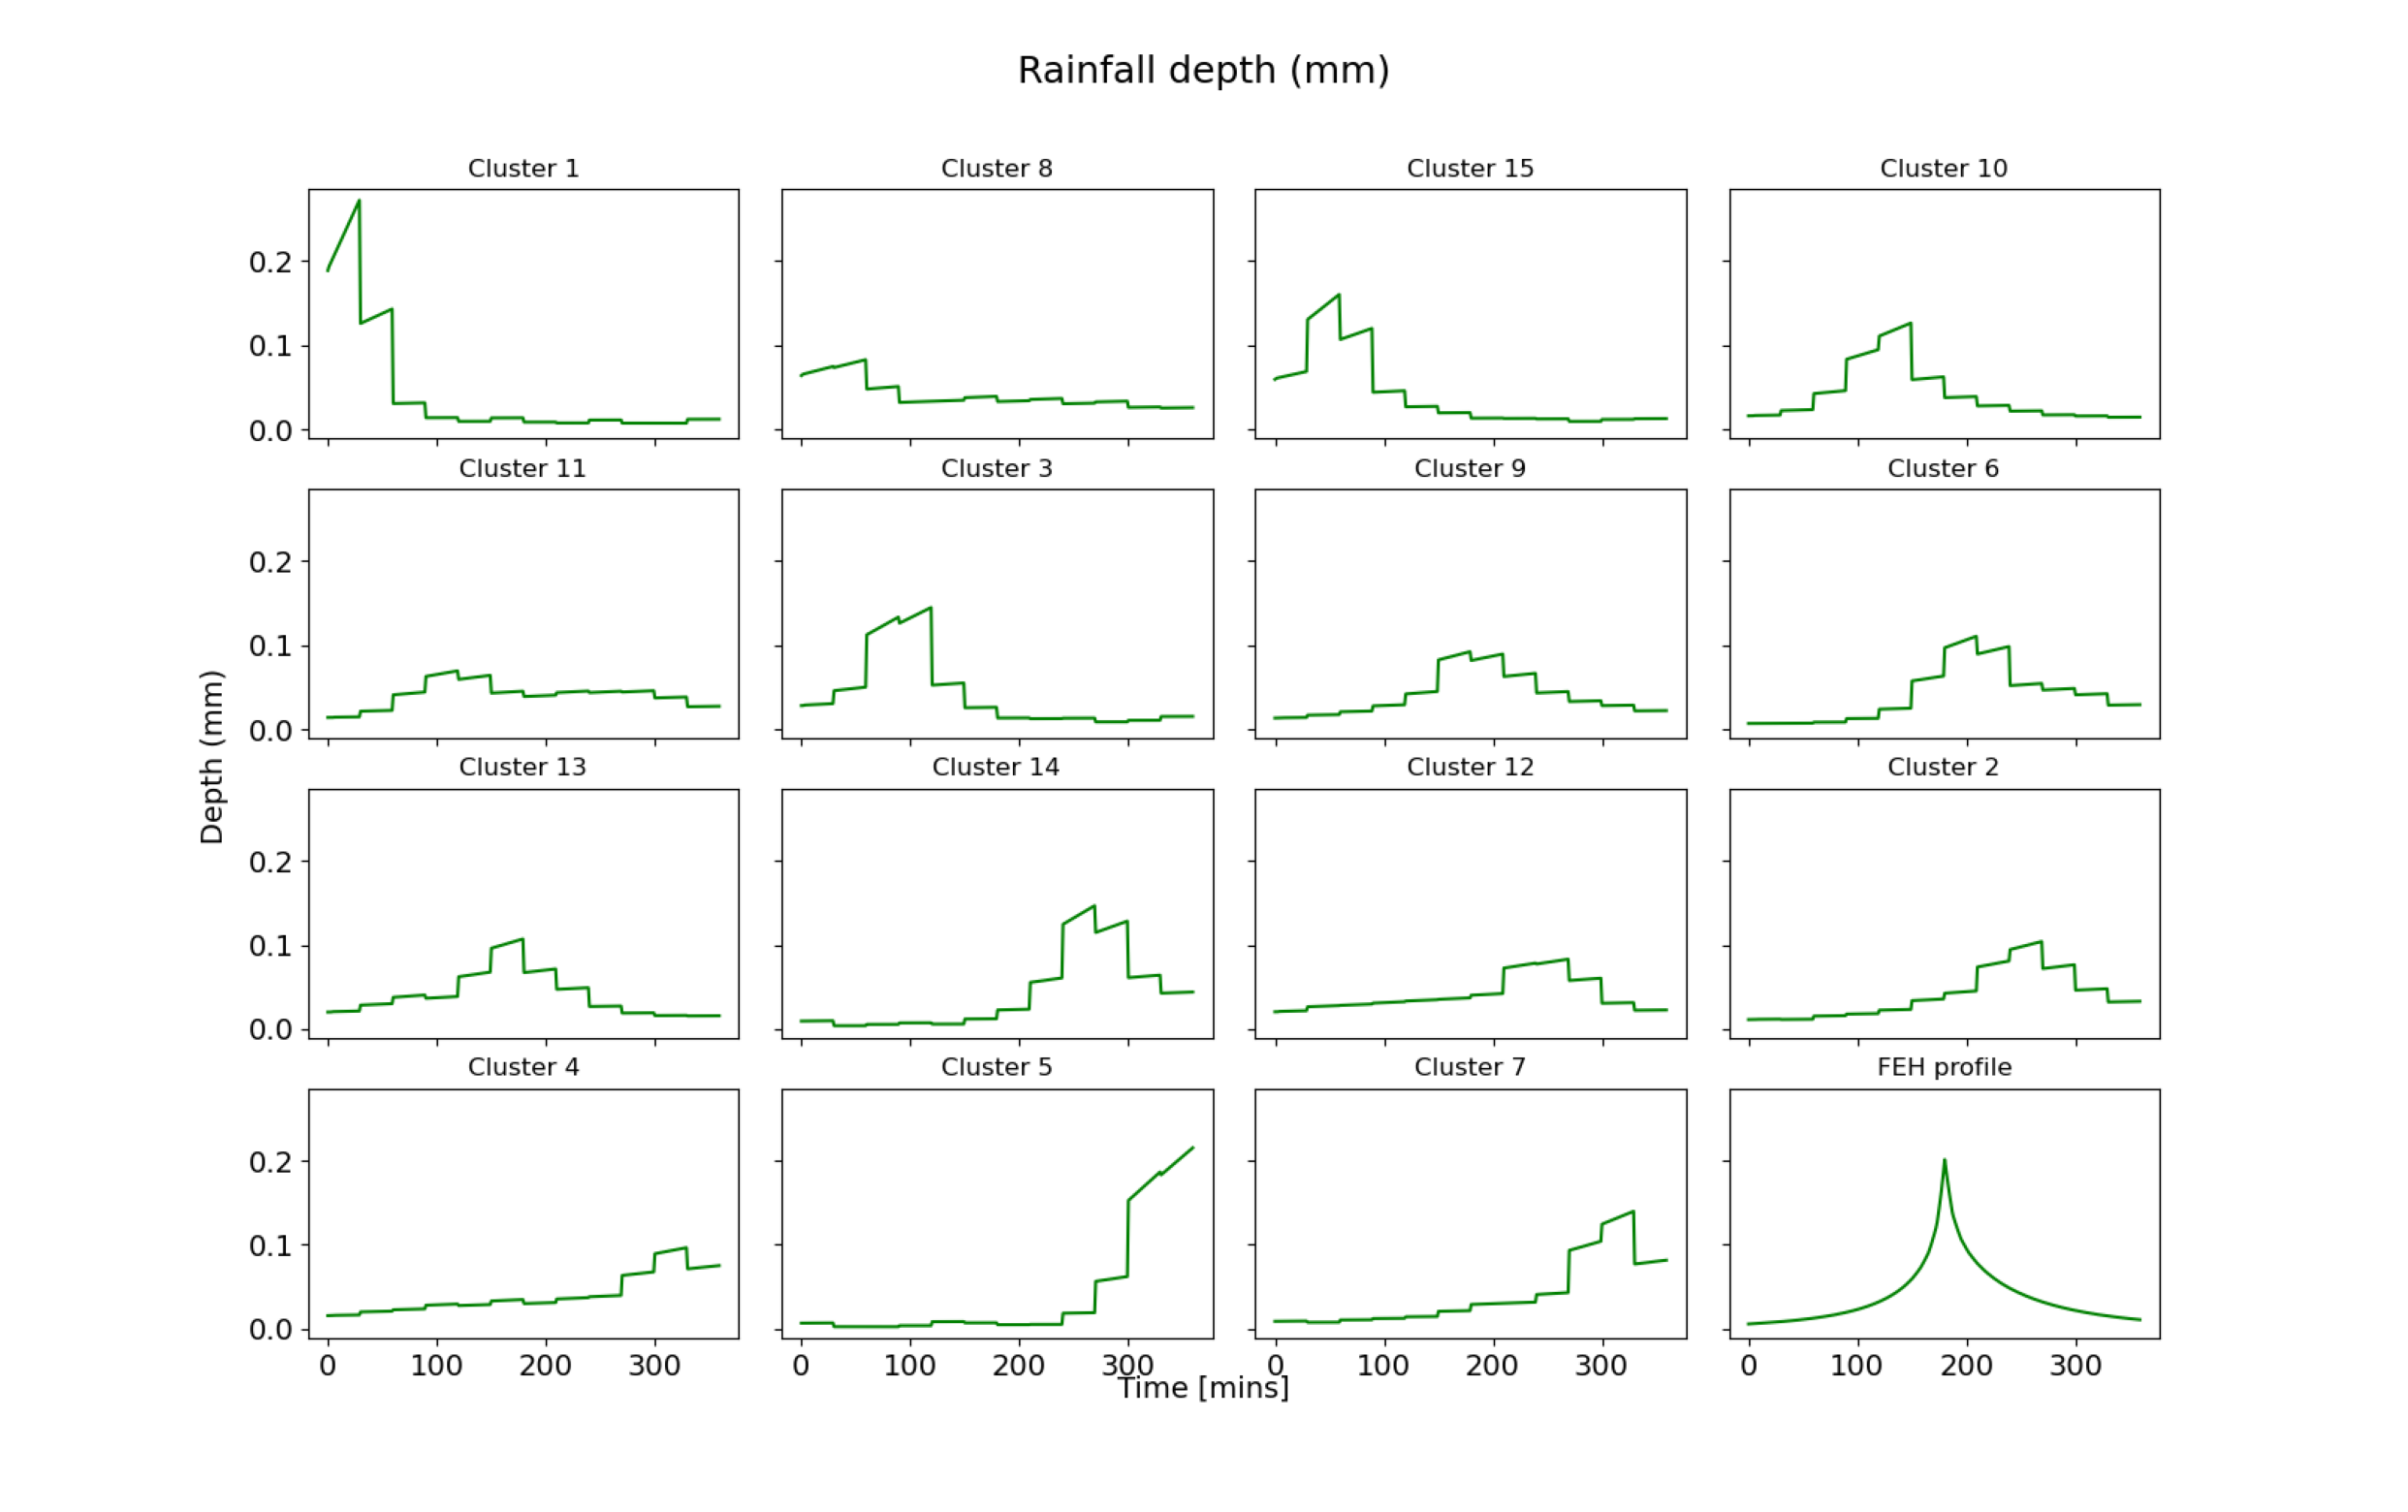

In [122]:
fig,ax =plt.subplots(figsize=(40,20))
img = Image.open("../../CreateSyntheticRainfallEvents/ObservedProfiles/6hr_100yrRP/PostLossRemoval/clusters_ordered_by_loadingstyle.png")
plt.axis('off')
plt.imshow(img);

### Read in landcover data

In [2]:
landcover, out_meta = prepare_rainfall_scenario_raster(model_directory + "LandCover_clipped.tif", True)

### Convert array values from 10 categories to just rural or urban
Convert the 1 and 6 values to 10 (for urban) and the rest to 11 (for non-urban).  

In [4]:
# Convert the two urban classes to 10
landcover_mod =  np.where(landcover==1, 10, landcover)
landcover_mod =  np.where(landcover_mod==6, 10, landcover_mod)
# Convert the rest of the classes to 11
for i in [1,2,3,4,5,7,8,9]:
    landcover_mod =  np.where(landcover_mod==i, 11, landcover_mod)

### Count the number of flooded cells in urban/rural areas

In [289]:
short_ids = ['6h_sp','6h_c1','6h_c2','6h_c3','6h_c4', '6h_c5', '6h_c6','6h_c7',
            '6h_c8','6h_c9', '6h_c10', '6h_c11','6h_c12','6h_c13','6h_c14', '6h_c15']   
methods = ['6h_single-peak', 'Cluster1', 'Cluster2', 'Cluster3', 'Cluster4', 'Cluster5', 'Cluster6', 'Cluster7', 'Cluster8',
           'Cluster9','Cluster10', 'Cluster11',  'Cluster12','Cluster13', 'Cluster14', 'Cluster15']  
loading_order = [0, 1, 8, 15, 10,11,3,9,6,13,14,12,2,4,5,7]
intensity_order = [1,5,0,15,14,3,7,10,6,13,2,4,9,12,8,11]
short_ids_by_loading = [short_ids[i] for i in loading_order]
short_ids_by_intensity = [short_ids[i] for i in intensity_order]

In [6]:
fps = []
for method_num, short_id in enumerate(short_ids):
    fp = model_directory + "{}/{} (Max).Resampled.Terrain.tif".format(short_id, '{}')
    fps.append(fp)

In [11]:
# Define breaks to split the depths/velocities on
breaks_depths = np.array([0, 0.3, 0.6, 1.2, 100])  
labels_depth = ['<=0.3m', '0.3-0.6m', '0.6-1.2m', '>1.2m']
breaks_velocity = np.array([0,0.25,0.5,2,100])
labels_velocity = ["<=0.25m/s", "0.25-0.5m/s", "0.5-2m/s", ">2m/s"]

velocity_counts, velocity_props = create_binned_counts_and_props(fps, 'Velocity', breaks_velocity, labels_velocity, remove_little_values)
depth_counts, depth_props = create_binned_counts_and_props(fps, 'Depth', breaks_depths, labels_depth, remove_little_values)

In [121]:
velocity_counts_urban, velocity_props_urban = create_binned_counts_and_props_urban(fps, 'Velocity', breaks_velocity, labels_velocity, remove_little_values)
depth_counts_urban, depth_props_urban = create_binned_counts_and_props_urban(fps, 'Depth', breaks_depths, labels_depth, remove_little_values)

#  Flood extent 
To examine whether the rainfall's temporal distribution influences the total extent of flooding, the number of flooded cells and the total flooded area in km2 (incl. only cells with depth >0.1m) is compared between the profile with a single peak, and the three methods for producing multi-peaked rainfall events. 

In [179]:
# Create one dataframe with each column the total number of flooded cells for each method 
totals_df = create_totals_df(velocity_counts)
totals_df_urban = create_totals_df(velocity_counts_urban)            
totals_df

,6h_sp,6h_c1,6h_c8,6h_c15,6h_c10,6h_c11,6h_c3,6h_c9,6h_c6,6h_c13,6h_c14,6h_c12,6h_c2,6h_c4,6h_c5,6h_c7
0,43.1988,44.358075,39.4507,42.66435,42.138175,42.138175,43.191025,41.974025,41.974025,41.85915,43.676875,41.410175,42.2026,41.9473,46.525625,43.71605


In [177]:
percent_diffs, percent_diffs_formatted_for_plot = find_percentage_diff (totals_df, fps) 
percent_diffs_urban, percent_diffs_formatted_for_plot_urban = find_percentage_diff (totals_df_urban, fps)   
percent_diffs 

[2.7, 8.7, 1.2, 2.5, 2.5, 0.0, 2.8, 2.8, 3.1, 1.1, 4.1, 2.3, 2.9, 7.7, 1.2]

In [280]:
percent_diffs_formatted_for_plot = []
percent_diffs= []
for fp in fps:
    rainfall_scenario_name = fp.split('/')[6]
    if rainfall_scenario_name!= '6h_sp':
        percent_diffs.append(round(abs(totals_df[rainfall_scenario_name]/totals_df['6h_sp'] - 1).values[0]*100,1)) 
        percent_diffs_formatted_for_plot.append((totals_df[rainfall_scenario_name]/totals_df['6h_sp'] - 1).values[0])
# Convert values to strings, and add a + sign for positive values
# Include an empty entry for the single peak scenario
percent_diffs_formatted_for_plot =[''] + ['+' + str(round((list_item *100),2)) + '%' if list_item > 0 else str(round((list_item *100),2)) + '%'  for list_item in percent_diffs_formatted_for_plot]

percent_diffs_df = pd.DataFrame({'percent_diffs': [0] + percent_diffs,
                                'percent_diffs_formatted': percent_diffs_formatted_for_plot}, index = short_ids)

percent_diffs_df = percent_diffs_df.T

In [285]:
short_ids_by_intensity.pop('6h_c1')

TypeError: 'str' object cannot be interpreted as an integer

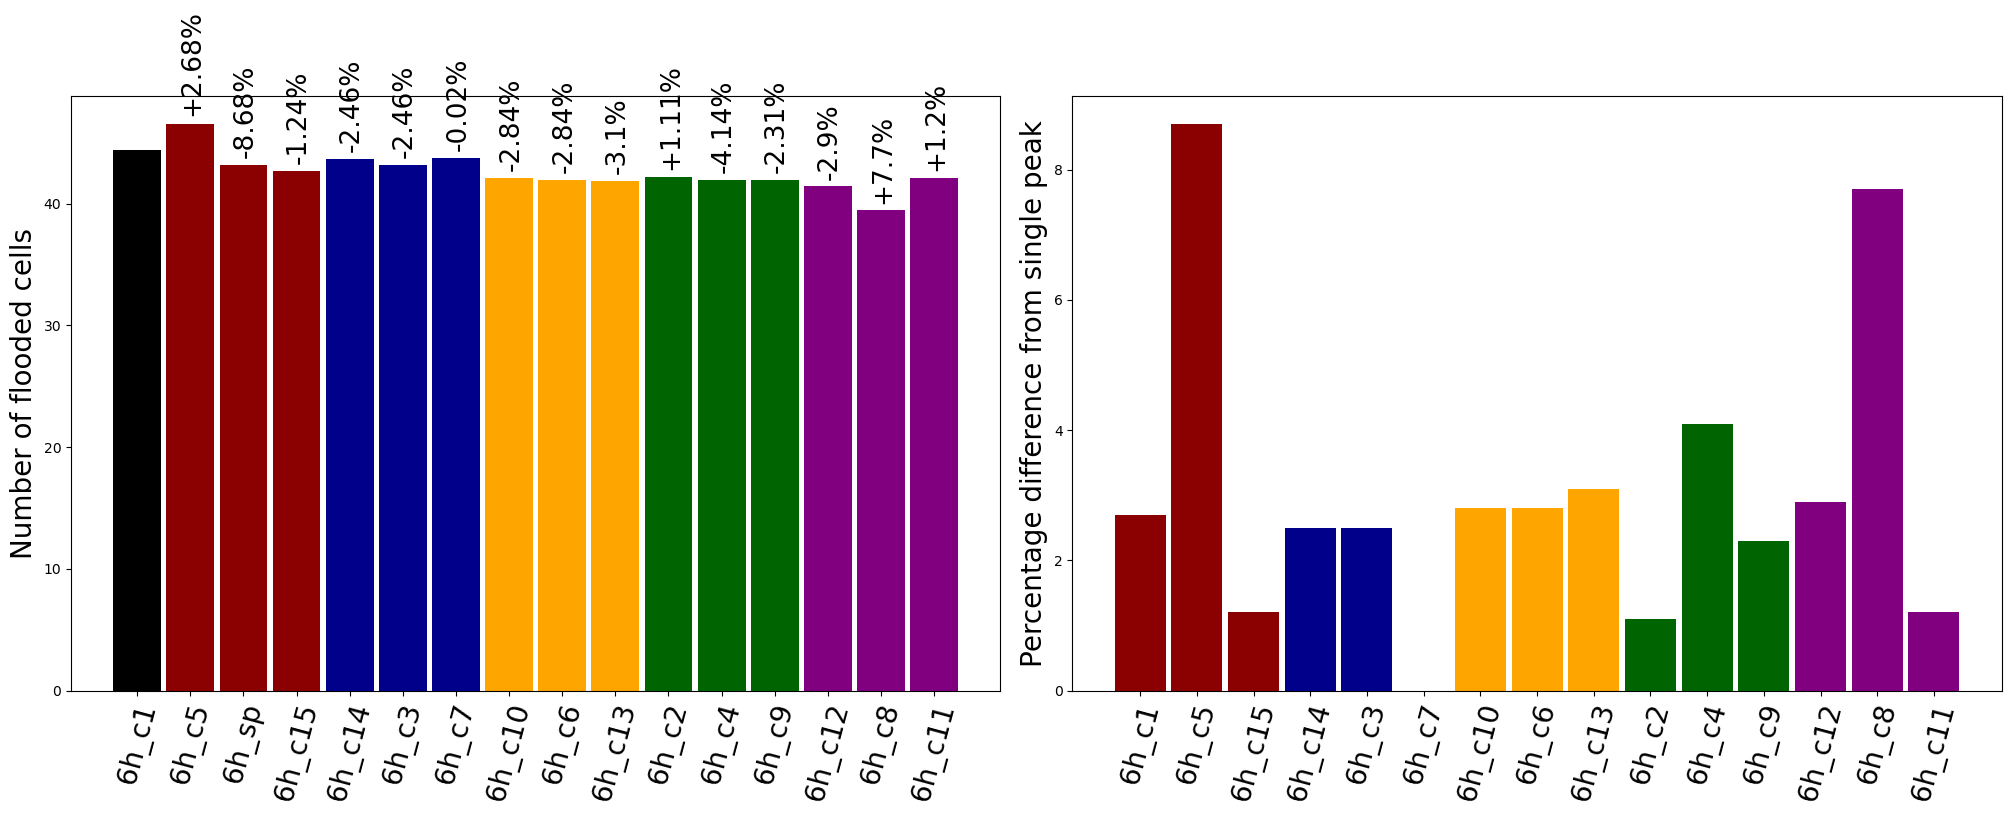

In [290]:
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize = (20,14))
y_pos = np.arange(len(totals_df.columns))
colors = ['black', 'darkred', 'darkred', 'darkred', 'darkblue', 'darkblue', 'darkblue', 'orange', 'orange', 'orange',
         'darkgreen', 'darkgreen', 'darkgreen', 'purple', 'purple', 'purple']

##############################
# Plot number of flooded cells
##############################
plt.subplot(221)
plt.bar(y_pos, totals_df.iloc[[0]].values.tolist()[0], width = 0.9, color = colors)
# Create names on the x-axis
plt.xticks(y_pos, short_ids_by_intensity, fontsize =20, rotation = 75)
# plt.xlabel('Method')
plt.ylabel('Number of flooded cells', fontsize =20)

xlocs, xlabs = plt.xticks(y_pos)
xlocs=[i+1 for i in range(0,19)]
xlabs=[i/2 for i in range(0,19)]

for i, v in enumerate(totals_df.iloc[[0]].values.tolist()[0]):
    plt.text(xlocs[i] - 1.2, v * 1.025, str(percent_diffs_df.T['percent_diffs_formatted'][i]), fontsize = 19, rotation =90)

# # ##############################
# # # Plot flooded extent in m2
# # # ##############################
percent_diffs_df_no_sp = percent_diffs_df.T
percent_diffs_df_no_sp = percent_diffs_df_no_sp.drop('6h_sp')
short_ids_by_intensity.remove('6h_sp')

plt.subplot(222)
plt.bar(np.arange(len(percent_diffs_df_no_sp['percent_diffs'])), percent_diffs_df_no_sp['percent_diffs'], width = 0.9, color = colors[1:])
# Create names on the x-axis
plt.xticks(np.arange(len(percent_diffs_df_no_sp['percent_diffs'])), short_ids_by_intensity, fontsize =20, rotation = 75)
# plt.xlabel('Method')
plt.ylabel('Percentage difference from single peak', fontsize =20);

## Total number of flooded cells/flooded area for each rainfall distribution (depths>0.1m)
<!-- This is assuming grid cells are 5m by 5m - but need to check this is correct.  
This plot is the same whether you use depth or velocity as the variable -->

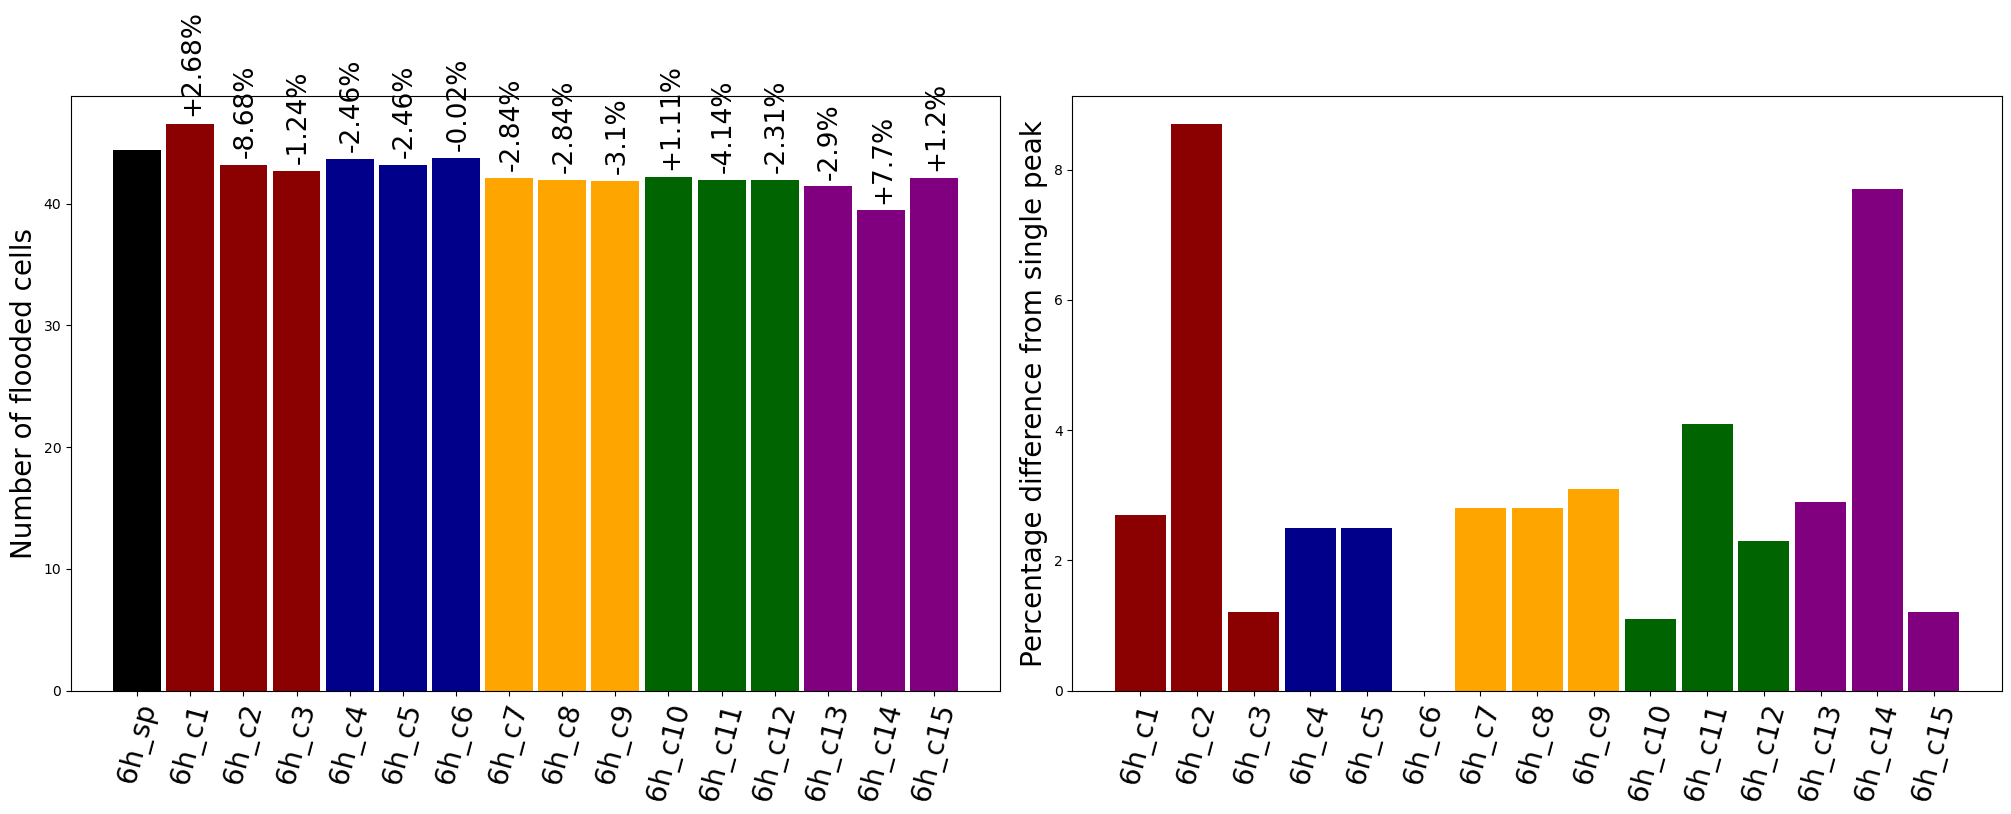

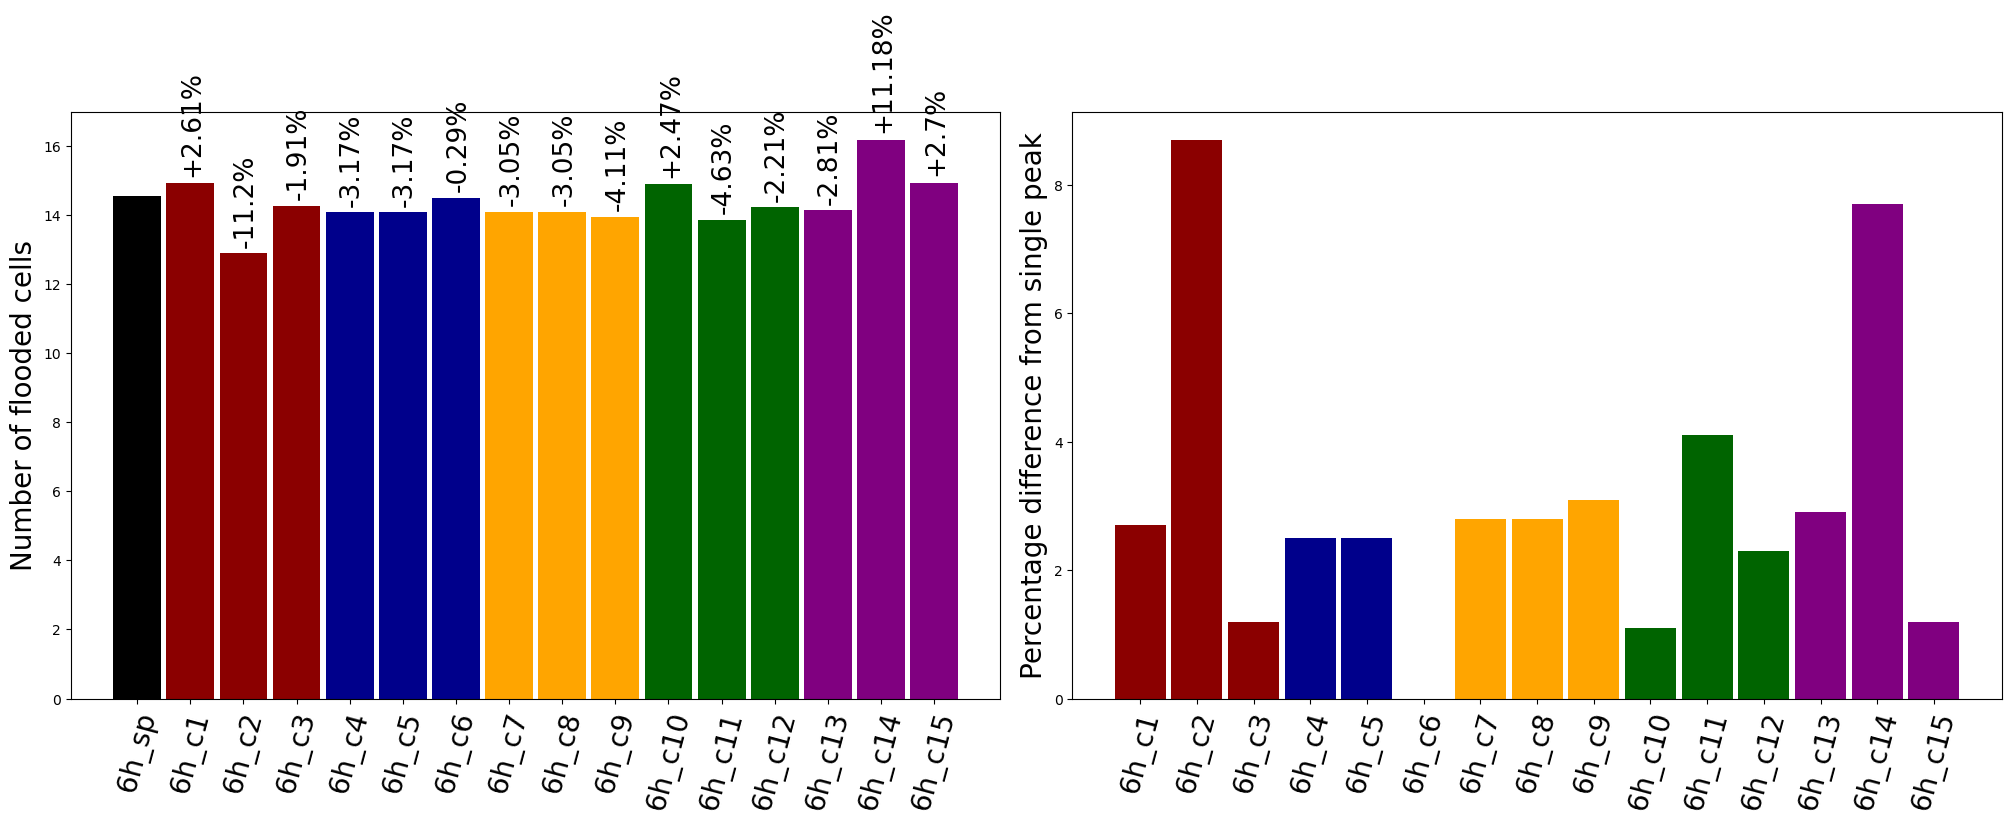

In [176]:
plot_totals(totals_df[short_ids_by_intensity], percent_diffs, percent_diffs_formatted_for_plot)
plot_totals(totals_df_urban, percent_diffs, percent_diffs_formatted_for_plot_urban)

## Reorder the columns to be in the order of peak intensity value
Could then arrange the plot using this

In [223]:
# peak_intensity_order = [1,5,15,14,3,10,7,6,13,9,8,2,4,11,12]
peak_intensity_order = percent_diffs_df['Cluster_num'].values
peak_intensity_order_formatted = ['6h_sp']
peak_intensity_order_formatted.extend(['6h_c' + str(s) for s in peak_intensity_order])
totals_df =  totals_df [peak_intensity_order_formatted]
percent_diffs_df['Flooded area'] =totals_df.T.iloc[1:,:].values
percent_diffs_df

,Cluster_num,PercentDiff,PeakIntensity,Flooded area
0,1,2.7,0.272517,1774387
4,5,2.5,0.215210,1861082
14,15,1.2,0.160460,1706631
13,14,7.7,0.146691,1747132
2,3,1.2,0.144710,1727698
6,7,2.8,0.139771,1748699
9,10,1.1,0.126434,1685584
5,6,0.0,0.110520,1679020
12,13,2.9,0.107119,1674425
1,2,8.7,0.104103,1688163


### Plot the maximum peak intensity value against the number of flooded cells

Text(0.5, 0, 'Percentage difference')

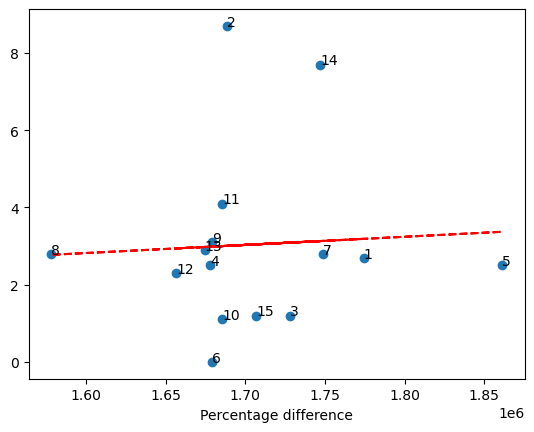

In [213]:
fig, ax = plt.subplots()
ax.scatter(percent_diffs_df['Flooded area'], percent_diffs_df['PercentDiff']);
z = np.polyfit(percent_diffs_df['Flooded area'], percent_diffs_df['PercentDiff'], 1)
p = np.poly1d(z)
ax.plot(percent_diffs_df['Flooded area'],p(percent_diffs_df['Flooded area']),"r--")
for i, txt in enumerate(percent_diffs_df['Cluster_num']):
    ax.annotate(txt, (percent_diffs_df['Flooded area'][i], percent_diffs_df['PercentDiff'][i]))
plt.xlabel('Peak Intensity (mm)')
plt.xlabel('Percentage difference')


In [ ]:
maxs = []
for cluster_num in range(1,16):
    precip=pd.read_csv("../../CreateSyntheticRainfallEvents/ObservedProfiles/6hr_100yrRP/PostLossRemoval/cluster{}_urban_summer.csv".format(cluster_num))
    precip=precip["Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model"]   
    maxs.append(precip.max())
peak_intensity = pd.DataFrame({'Cluster_num': range(1,16), "Max": maxs   }) 

In [217]:
fig, ax = plt.subplots()
percent_diffs_df = percent_diffs_df.sort_values('PeakIntensity', ascending = False)
ax.scatter(df['Max'], percent_diffs_df['PercentDiff']);
z = np.polyfit(df['Max'], percent_diffs_df['PercentDiff'], 1)
p = np.poly1d(z)
ax.plot(df['Max'],p(df['Max']),"r--")
for i, txt in enumerate(df['Cluster_num']):
    ax.annotate(txt, (df['Max'][i], percent_diffs_df['PercentDiff'][i]))
plt.xlabel('Peak Intensity (mm)')
plt.xlabel('Percentage difference')

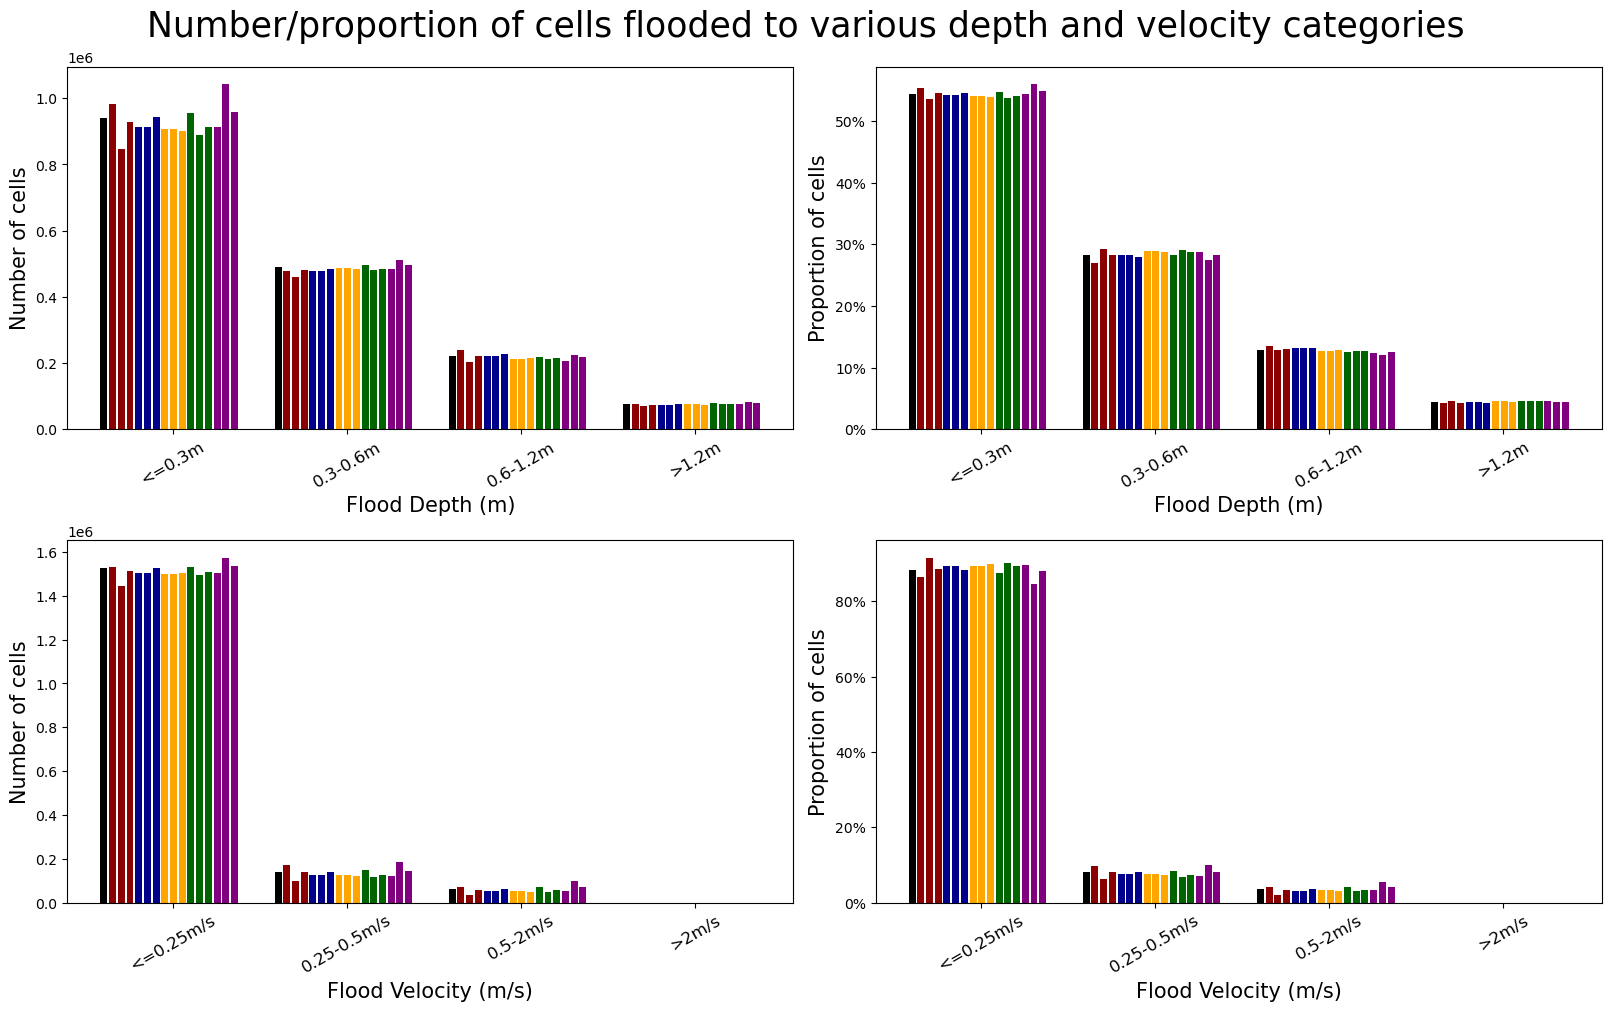

In [219]:
fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize = (16,10))
fig.suptitle('Number/proportion of cells flooded to various depth and velocity categories', fontsize = 25)
subplot_n = [221, 222, 223, 224]
subplot_i = 0

colors = ['black', 'darkred', 'darkred', 'darkred', 'darkblue', 'darkblue', 'darkblue', 'orange', 'orange', 'orange',
         'darkgreen', 'darkgreen', 'darkgreen', 'purple', 'purple', 'purple']
units_dict = {'Depth': 'm', 'Velocity': 'm/s'}    

for row, variable in enumerate(["Depth", "Velocity"]):
    
    # Create...
    if variable == 'Depth':
        counts_df, props_df = depth_counts, depth_props 
    elif variable == 'Velocity':
        counts_df, props_df = velocity_counts, velocity_props 
    
    ################# Plot
    labels = counts_df['index']
    x = np.arange(len(counts_df['index']))
    width = 0.3
    
    # counts_df plotting
    width, DistBetweenBars, Num = 0.04, 0.01, 16 # width of each bar, distance between bars, number of bars in a group
    # calculate the width of the grouped bars (including the distance between the individual bars)
    WithGroupedBars = Num*width + (Num-1)*DistBetweenBars
    plt.subplot(subplot_n[subplot_i])
    for i in range(Num):
        plt.bar(np.arange(len(counts_df))-WithGroupedBars/2 + (width+DistBetweenBars)*i, counts_df.iloc[:,i+1], width, 
                color = colors[i])
    plt.xticks(np.arange(len(counts_df['index'])), counts_df['index'], rotation=30, fontsize = 12)
    plt.xlabel('Flood {} ({})'.format(variable, units_dict[variable]), fontsize = 15)
    plt.ylabel('Number of cells', fontsize = 15)
   
    # Proportions_df plotting
    subplot_i = subplot_i+ 1        
    plt.subplot(subplot_n[subplot_i])
    for i in range(Num):
        plt.bar(np.arange(len(counts_df))-WithGroupedBars/2 + (width+DistBetweenBars)*i, props_df.iloc[:,i+1], width, 
                color = colors[i])
    plt.xticks(np.arange(len(props_df['index'])), props_df['index'], rotation=30, fontsize = 12)
    plt.xlabel('Flood {} ({})'.format(variable, units_dict[variable]), fontsize = 15)
    plt.ylabel('Proportion of cells', fontsize = 15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    subplot_i = subplot_i+ 1 

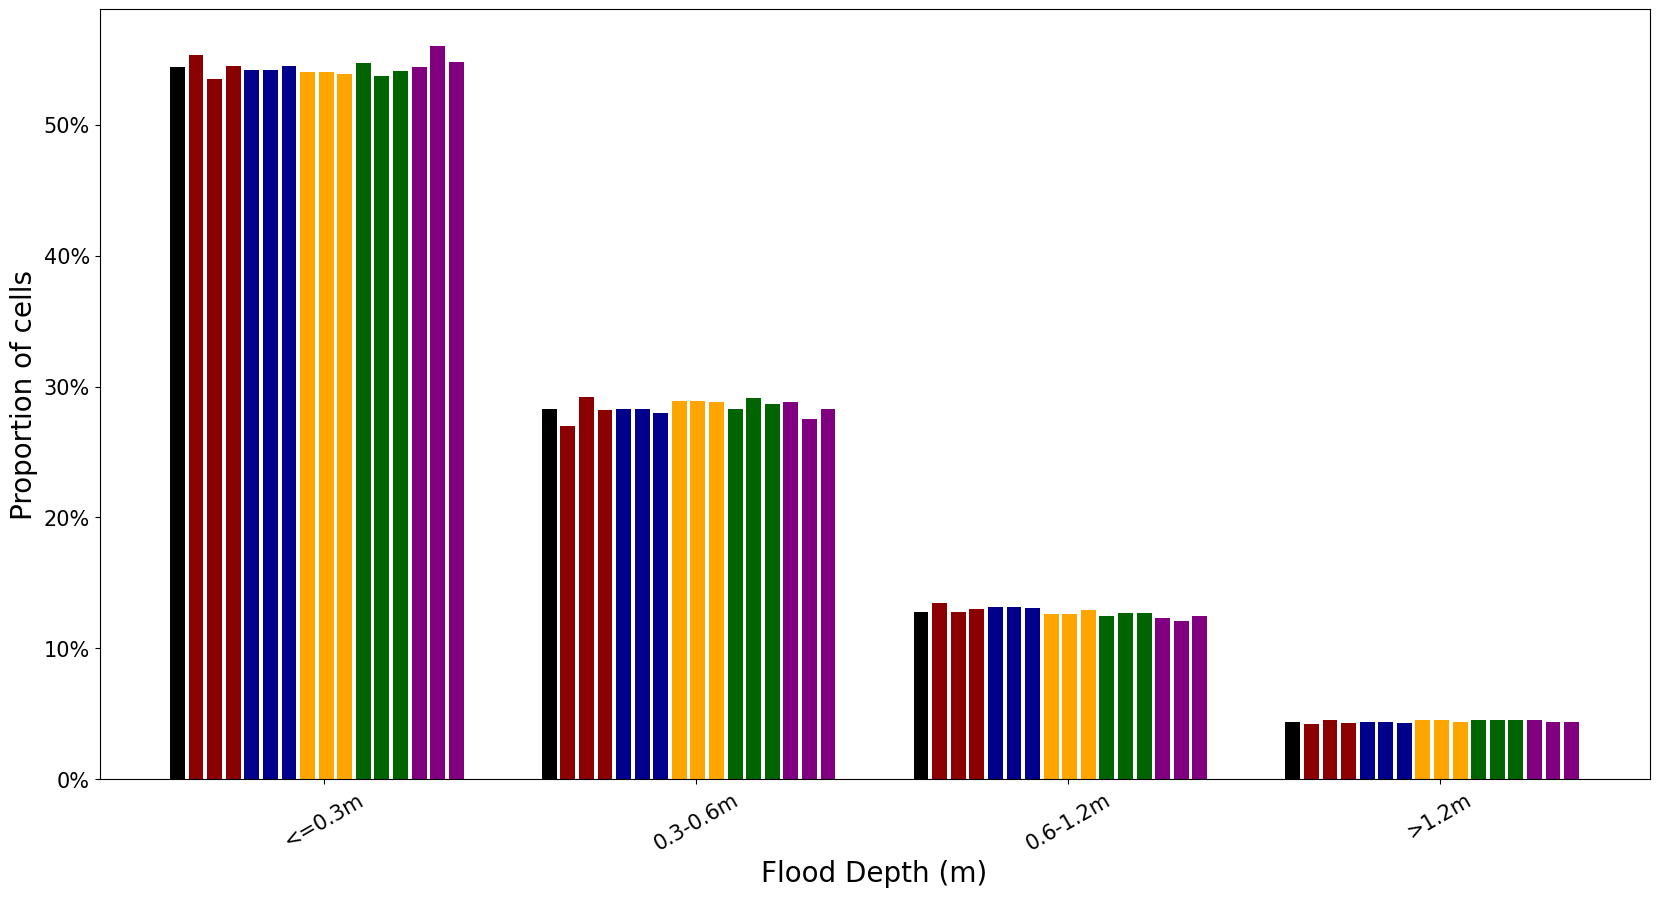

In [220]:
fig, ax =plt.subplots(figsize =(20,10))
for i in range(Num):
    plt.bar(np.arange(len(depth_counts))-WithGroupedBars/2 + (width+DistBetweenBars)*i, depth_props.iloc[:,i+1], width, 
            color = colors[i])
plt.xticks(np.arange(len(depth_props['index'])), depth_props['index'], rotation=30, fontsize = 15)
plt.yticks(fontsize=15)
plt.xlabel('Flood Depth (m)', fontsize = 20)
plt.ylabel('Proportion of cells', fontsize = 20)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

## Number of cells in which each method leads to the worst flooding (depth/velocity)
Check what happens in the case where the flood depth/velocity is equal

In [221]:
worst_case_method_depth = find_worst_case_method(fps, short_ids, 'Depth')
worst_case_method_velocity = find_worst_case_method(fps, short_ids,  'Velocity') 

In [222]:
worst_case_method_depth = worst_case_method_depth[~worst_case_method_depth['values'].isin(['multiple matches','nan'])]
worst_case_method_velocity = worst_case_method_velocity[~worst_case_method_velocity['values'].isin(['multiple matches','nan'])]
worst_case_method_depth

,values,counts
0,6h_c1,284888
1,6h_c12,4242
2,6h_c13,3207
3,6h_c14,7197
4,6h_c15,1510
5,6h_c2,1300
6,6h_c3,121096
7,6h_c4,16662
8,6h_c5,1050480
9,6h_c7,3694


<AxesSubplot:ylabel='Number of cells'>

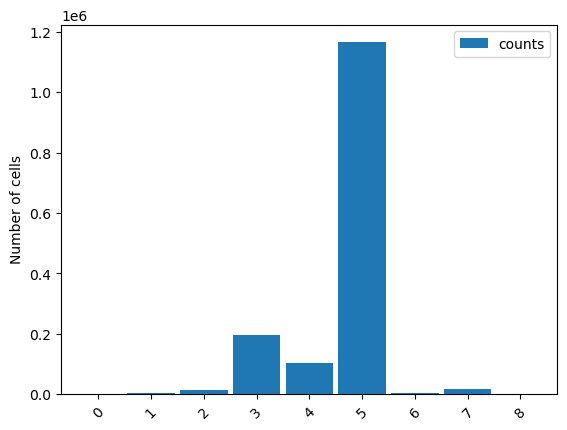

In [58]:
fig, ax  = plt.subplots()
worst_case_method_depth.plot(ax= ax, kind ='bar',width=  0.9, rot =45, ylabel = 'Number of cells')      
# def plot_worst_case_bars (ax, worst_case_method_df):
#     # Remove the np.nan values
#     worst_case_method_df = worst_case_method_df.iloc[:5,1]
#     # Set scenario names as index
#     worst_case_method_df.index = ["singlepeak", "dividetime", "subpeaktiming", "maxspread", "no maximum"]
#     # Plot
#     worst_case_method_df.plot(ax= ax, kind ='bar',width=  0.9, rot =45, ylabel = 'Number of cells')  

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize = (16,6))
plot_worst_case_bars(axs[0],worst_case_method_df)
plot_worst_case_bars(axs[1],worst_case_method_velocity)
fig.suptitle('Number cells where each method produces the deepest (left) and fastest (right) flooding', fontsize = 20)

## Spatial extent of flooding, by depth category (for d >0.1m) for each rainfall distribution

In [ ]:
# short_ids_less= ['6h_sp', '6h_dt', '6h_ms', '6h_spt', '6h_c1', '6h_c5', '6h_c8', '6h_c11', '6h_c12']
# fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(40,36))
# for number, short_id in enumerate(short_ids_less):
#     fp = 'Figs/{}/Depth_classified.png'.format(short_id)
#     make_spatial_plot(axes.flat[number],fp)
# fig.tight_layout()
# # plt.subplots_adjust(left=0.125,bottom=0.1, right=0.5, top=0.5, wspace=-0.6, hspace=0)

## Spatial extent of flooding, by velocity category (for d >0.1m) for each rainfall distribution

In [ ]:
# short_ids_less= ['6h_sp', '6h_dt', '6h_ms', '6h_spt', '6h_c1', '6h_c5', '6h_c8', '6h_c11', '6h_c12']
# fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(40,36))
# for number, short_id in enumerate(short_ids_less):
#     fp = 'Figs/{}/Velocity_classified.png'.format(short_id)
#     make_spatial_plot(axes.flat[number],fp)
# fig.tight_layout()
# plt.subplots_adjust(left=0.125,bottom=0.1, right=0.5, top=0.5, wspace=-0.6, hspace=0)

In [ ]:
# # Create discrete cmap
# colors_list = [mpl.cm.Blues(0.2), mpl.cm.Blues(0.5), mpl.cm.Blues(0.7),"navy"]
# cmap = mpl.colors.ListedColormap(colors_list)

# my_dict = {"dividetime":"Arcpy/depth_dividetime_reclassified.tif",
#            "maxspread":"Arcpy/depth_maxspread_reclassified.tif",
#            "subpeaktiming":"Arcpy/depth_subpeaktiming_reclassified.tif",
#            "singlepeak": "Arcpy/depth_singlepeak_reclassified.tif"}    

# plot_with_folium(my_dict, cmap, template_depth_cats)

In [ ]:
# # Create discrete cmap
# colors_list = [mpl.cm.cool(0.3), mpl.cm.cool(0.5), mpl.cm.cool(0.7), mpl.cm.cool(0.9)]
# cmap2 = mpl.colors.ListedColormap(colors_list)

# my_dict = {"dividetime":"Arcpy/velocity_dividetime_reclassified.tif",
#            "maxspread":"Arcpy/velocity_maxspread_reclassified.tif",
#            "subpeaktiming":"Arcpy/velocity_subpeaktiming_reclassified.tif",
#            "singlepeak": "Arcpy/velocity_singlepeak_reclassified.tif"}    

# plot_with_folium(my_dict, cmap2, template = template_velocity_cats)

## Difference in flood depth between a single peak and each of the multi-peaked methods
A positive difference implies that the flooding is deeper in the single peak method, whilst a negative difference implies the opposite.

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(35,30))
for number, short_id in enumerate(short_ids_less):
    fp = 'Figs/{}/Depth_difffromsinglepeak_classified.png'.format(short_id)
    make_spatial_plot(axes.flat[number],fp)
# for number, short_id in enumerate(short_ids_less):
#     fp = 'Figs/{}/Depth_difffromsinglepeak_posneg.png'.format(short_id)
#     make_spatial_plot(axes.flat[number+3],fp)    
fig.tight_layout()    

### Difference in flood velocity between a single peak and each of the multi-peaked methods
A positive difference implies that the flooding is deeper/faster in the single peak method, whilst a negative difference implies the opposite

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(35,30))
for number, short_id in enumerate(short_ids_less):
    fp = 'Figs/{}/Velocity_difffromsinglepeak_classified.png'.format(short_id)
    make_spatial_plot(axes.flat[number],fp)
for number, short_id in enumerate(short_ids_less):
    fp = 'Figs/{}/Velocity_difffromsinglepeak_posneg.png'.format(short_id)
    make_spatial_plot(axes.flat[number+3],fp)    
fig.tight_layout()    

In [ ]:
# # raster = prepare_rainfall_scenario_raster(fps[1].format('velocity'), remove_little_values)[0]
# # raster, out_meta = open_and_clip(fps[1].format('velocity'))

# # Read in data as array
# data = rasterio.open(fps[1].format('Velocity'))
# # Create a bounding box 
# minx, miny = 437000,  426500
# maxx, maxy = 445500, 434300
# bbox = box(minx, miny, maxx, maxy)
# # Insert the bbox into a GeoDataFrame
# geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0])
# # Re-project into the same coordinate system as the raster data
# geo = geo.to_crs(crs=CRS('EPSG:27700'))#data.crs.data

# # Next we need to get the coordinates of the geometry in such a format
# # that rasterio wants them. This can be conducted easily with following function
# def getFeatures(gdf):
#     """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
#     import json
#     return [json.loads(gdf.to_json())['features'][0]['geometry']]
# # Get the geometry coordinates by using the function.
# coords = getFeatures(geo)

# # Clip the raster with the polygon using the coords variable that we just created. Clipping the raster can be done easily 
# # with the mask function and specifying clip=True.
# clipped_array, out_transform = mask(data, shapes=coords, crop=True)

# # Set -9999 to NA
# clipped_array[clipped_array < -9998] = np.nan

# # Modify the metadata. Let’s start by copying the metadata from the original data file.
# out_meta = data.meta.copy()